# mapping of reads

In [1]:
!python flair/flair.py align -r fastq/HEK293FT_pBZ105_UGAC.fastq.gz -g reporter_seqs/pBZ105_and_K0.fa -v1.3 --nvrna --threads 48 --output HEK293FT_pBZ105_UGAC

[M::mm_idx_gen::0.003*0.00] collected minimizers
[M::mm_idx_gen::0.006*3.18] sorted minimizers
[M::main::0.006*3.16] loaded/built the index for 2 target sequence(s)
[M::mm_mapopt_update::0.007*2.96] mid_occ = 5
[M::mm_idx_stat] kmer size: 14; skip: 5; is_hpc: 0; #seq: 2
[M::mm_idx_stat::0.007*2.80] distinct minimizers: 5134 (85.02% are singletons); average occurrences: 1.177; average spacing: 2.979
[M::worker_pipeline::13.130*7.96] mapped 480049 sequences
[M::worker_pipeline::26.522*7.45] mapped 491276 sequences
[M::worker_pipeline::30.501*7.53] mapped 235573 sequences
[M::main] Version: 2.16-r922
[M::main] CMD: minimap2 -ax splice -uf -k14 -t 48 --secondary=no reporter_seqs/pBZ105_and_K0.fa fastq/HEK293FT_pBZ105_UGAC.fastq.gz
[M::main] Real time: 30.508 sec; CPU: 229.528 sec; Peak RSS: 2.691 GB
Converting sam output to bed
[bam_sort_core] merging from 0 files and 48 in-memory blocks...


In [2]:
!python flair/flair.py align -r fastq/HEK293FT_pBZ147_AQP4.fastq.gz -g reporter_seqs/pBZ147_and_K20.fa  -v1.3 --nvrna --threads 48 --output HEK293FT_pBZ147_AQP4

[M::mm_idx_gen::0.004*1.08] collected minimizers
[M::mm_idx_gen::0.008*4.41] sorted minimizers
[M::main::0.008*4.39] loaded/built the index for 2 target sequence(s)
[M::mm_mapopt_update::0.009*4.02] mid_occ = 5
[M::mm_idx_stat] kmer size: 14; skip: 5; is_hpc: 0; #seq: 2
[M::mm_idx_stat::0.009*3.79] distinct minimizers: 5154 (85.06% are singletons); average occurrences: 1.185; average spacing: 2.961
[M::worker_pipeline::14.800*5.93] mapped 528111 sequences
[M::worker_pipeline::21.919*6.46] mapped 341414 sequences
[M::main] Version: 2.16-r922
[M::main] CMD: minimap2 -ax splice -uf -k14 -t 48 --secondary=no reporter_seqs/pBZ147_and_K20.fa fastq/HEK293FT_pBZ147_AQP4.fastq.gz
[M::main] Real time: 21.932 sec; CPU: 141.612 sec; Peak RSS: 2.127 GB
Converting sam output to bed
[bam_sort_core] merging from 0 files and 48 in-memory blocks...


In [3]:
def convertFastaToDict(fastaFile):
    '''
    converts a fasta file to a dict of {sequenceName:sequence}
    can take extra files in * args
    '''
    if isinstance(fastaFile, list):
        files = fastaFile
    else:
        files = [fastaFile]
    currentName = None
    currentSequence = None
    seqDict = {}
    for currentFile in files:
        if currentFile.endswith('.gz'):
            f = gzip.open(currentFile)
        else:
            f = open(currentFile)
        for line in f:
            if not line.strip() == '' and not line.startswith('#'):  # ignore empty lines and commented out lines
                if line.startswith('>'):  # > marks the start of a new sequence
                    if not currentName == None:  # after we've reached the firtst > line, we know what the sequence corresponds to
                        seqDict[currentName] = currentSequence
                    currentName = line.strip()[1:].split()[
                        0]  # i've noticed the gencode names have extraneous numbering after some whitespace. This doens't match the GTF files, so I'm removing it.
                    currentSequence = ''
                else:
                    currentSequence += line.strip()
        f.close()
    seqDict[currentName] = currentSequence
    return seqDict


In [4]:
#import reads
import pysam
from collections import defaultdict

pBZ105_seqs = convertFastaToDict('reporter_seqs/pBZ105_and_K0.fa')
pBZ147_seqs = convertFastaToDict('reporter_seqs/pBZ147_and_K20.fa')
print(pBZ105_seqs.keys())
print(pBZ147_seqs.keys())

pBZ105_bam = pysam.AlignmentFile('HEK293FT_pBZ105_UGAC.bam', "rb")
pBZ147_bam = pysam.AlignmentFile('HEK293FT_pBZ147_AQP4.bam', "rb")

['pBZ105_lenti_tagBF_2A_UGAC_2A_tdTomato', 'pmGFP_P2A_K0_P2A_RFP']
['pBZ147_lenti_tagBF_2A_AQP4_2A_tdTomato', 'pmGFP_P2A_K20_P2A_RFP']


Parse reads

In [5]:
#get read ends
pBZ105_reads = [r for r in pBZ105_bam.fetch(reference = 'pBZ105_lenti_tagBF_2A_UGAC_2A_tdTomato') if (not r.is_secondary) and (not r.is_reverse)]
pBZ147_reads = [r for r in pBZ147_bam.fetch(reference='pBZ147_lenti_tagBF_2A_AQP4_2A_tdTomato') if (not r.is_secondary) and (not r.is_reverse)]

pBZ105_5p_ends = defaultdict(int)
pBZ105_3p_ends = defaultdict(int)
for read in [r for r in pBZ105_reads if (not r.is_secondary) and (not r.is_reverse)]:
    pBZ105_5p_ends[read.reference_start] = pBZ105_5p_ends[read.reference_start] + 1 #0-based start of fragment
    pBZ105_3p_ends[read.reference_end-1] = pBZ105_3p_ends[read.reference_end-1] + 1

pBZ147_5p_ends = defaultdict(int)
pBZ147_3p_ends = defaultdict(int)
for read in [r for r in pBZ147_reads if (not r.is_secondary) and (not r.is_reverse)]:
    pBZ147_5p_ends[read.reference_start] = pBZ147_5p_ends[read.reference_start] + 1 #0-based start of fragment
    pBZ147_3p_ends[read.reference_end-1] = pBZ147_3p_ends[read.reference_end-1] + 1

In [6]:
#get coverage
def check_read(r):
    if (not r.is_secondary) and (not r.is_reverse):
        return True
    return False

def get_coverage(bam, reference):
    coverage_dict = defaultdict(int)
    for pileupcolumn in bam.pileup(reference):
        pos = pileupcolumn.pos
        coverage = len([pileupread for pileupread in pileupcolumn.pileups if check_read(pileupread.alignment)])
        coverage_dict[pos] = coverage
    return coverage_dict

pBZ105_coverage = get_coverage(pBZ105_bam, 'pBZ105_lenti_tagBF_2A_UGAC_2A_tdTomato')
pBZ147_coverage = get_coverage(pBZ147_bam, 'pBZ147_lenti_tagBF_2A_AQP4_2A_tdTomato')

In [7]:
#get introns
import operator
print (len(pBZ105_reads))
introns = pBZ105_bam.find_introns(pBZ105_reads)

seq = pBZ105_seqs['pBZ105_lenti_tagBF_2A_UGAC_2A_tdTomato']
filtered_introns = dict()
for intron in introns:
    if intron[1] is not None and intron[0] is not None and (intron[1] - intron[0]) > 24:
        #The shortest intron sequence is 30 bp long and belongs to the MST1L gene of H. sapiens 
        #(Gene ID: 11223, Taxonomy ID: 9606), encoding for the putative macrophage stimulating 1-like protein.
        #PMC4675715
        splice_5p_seq = seq[intron[0] : intron[0]+2]
        splice_3p_seq = seq[intron[1]-2 : intron[1]]
        if splice_5p_seq.upper() == 'GT' and splice_3p_seq.upper() == 'AG' and introns[intron]>1:
            filtered_introns.update({intron:introns[intron]})
            #print(intron, introns[intron], splice_5p_seq, splice_3p_seq)
#sorted_filtered_introns = sorted(filtered_introns.items(), key=operator.itemgetter(1))
#list(reversed(sorted_filtered_introns))

#normalize each intron by the number of reads spanning it

normalized_introns = {}
for intron in filtered_introns.keys():
    num_overlapping_reads = len([r for r in pBZ105_reads if (r.reference_start<intron[0] and r.reference_end>intron[1])])
    if filtered_introns[intron]/float(num_overlapping_reads)>=0.01:
        normalized_introns.update({intron:filtered_introns[intron]/float(num_overlapping_reads)})

pBZ105_normalized_introns = normalized_introns
   
sorted_normalized_introns = sorted(normalized_introns.items(), key=operator.itemgetter(1))
#list(reversed(sorted_normalized_introns))
sum([i[1] for i in list(reversed(sorted_normalized_introns))[1:]])

8064


1.2009368545358385

In [8]:
#get introns

import operator
print (len(pBZ147_reads))
introns = pBZ147_bam.find_introns(pBZ147_reads)

seq = pBZ147_seqs['pBZ147_lenti_tagBF_2A_AQP4_2A_tdTomato']
filtered_introns = dict()
for intron in introns:
    if intron[1] is not None and intron[0] is not None and (intron[1] - intron[0]) > 24:
        #The shortest intron sequence is 30 bp long and belongs to the MST1L gene of H. sapiens 
        #(Gene ID: 11223, Taxonomy ID: 9606), encoding for the putative macrophage stimulating 1-like protein.
        #PMC4675715
        splice_5p_seq = seq[intron[0] : intron[0]+2]
        splice_3p_seq = seq[intron[1]-2 : intron[1]]
        if splice_5p_seq.upper() == 'GT' and splice_3p_seq.upper() == 'AG' and introns[intron]>1:
            filtered_introns.update({intron:introns[intron]})
            #print(intron, introns[intron], splice_5p_seq, splice_3p_seq)
#sorted_filtered_introns = sorted(filtered_introns.items(), key=operator.itemgetter(1))
#list(reversed(sorted_filtered_introns))

#normalize each intron by the number of reads spanning it

normalized_introns = {}
for intron in filtered_introns.keys():
    num_overlapping_reads = len([r for r in pBZ147_reads if (r.reference_start<intron[0] and r.reference_end>intron[1])])
    if filtered_introns[intron]/float(num_overlapping_reads)>=0.01:
        normalized_introns.update({intron:filtered_introns[intron]/float(num_overlapping_reads)})

pBZ147_normalized_introns = normalized_introns
   
sorted_normalized_introns = sorted(normalized_introns.items(), key=operator.itemgetter(1))
#list(reversed(sorted_normalized_introns))
sum([i[1] for i in list(reversed(sorted_normalized_introns))[1:]])

7777


1.610748022239938

plot reads

In [9]:
#colors - colorblind safe
black = (0,0,0)
gray = (0.6,0.6,0.6)
orange = (230/255.0,159/255.0,0)
skyBlue = (86/255.0,180/255.0,233/255.0)
bluishGreen = (0,158/255.0,115/255.0)
yellow = (240/255.0,228/255.0,66/255.0)
blue = (0,114/255.0,178/255.0)
vermillion = (213/255.0,94/255.0,0)
reddishPurple = (204/255.0,121/255.0,167/255.0)
colors = [black, vermillion, orange, skyBlue, bluishGreen, blue, reddishPurple, yellow, gray]

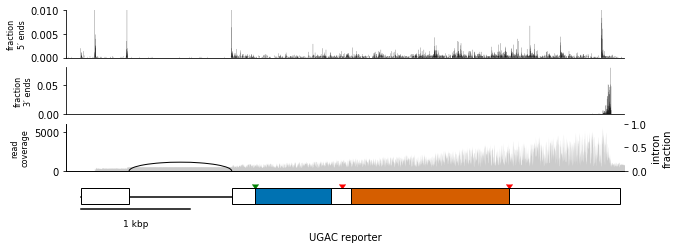

In [10]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats as stats
import numpy as np
plt.rcParams['pdf.fonttype'] = 42 #leaves most text as actual text in PDFs, not outlines
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

plots=[]
num_plots_wide = 1
num_plots_high = 4
fig, plots = plt.subplots(num_plots_high, figsize=(10*num_plots_wide, 1*num_plots_high), sharex=True)

positions = np.arange(5200)

ends_5p = np.array([float(pBZ105_5p_ends[pos]) for pos in positions])
ends_3p = np.array([float(pBZ105_3p_ends[pos]) for pos in positions])

plots[0].bar(positions-0.5, ends_5p/sum(ends_5p), color=black, linewidth=0, width=2, align='edge', alpha=1, snap=False, label='fraction 5prime ends')
plots[0].set_ylabel(u'fraction\n5′ ends', fontsize=8)
plots[0].set_ylim(0,0.01)

plots[1].bar(positions-0.5, ends_3p/sum(ends_3p), color=black, linewidth=0, width=2, align='edge', alpha=1, snap=False, label='fraction 3prime ends')
plots[1].set_ylabel(u'fraction\n3′ ends', fontsize=8)
plots[1].set_ylim(0,0.08)


coverage = np.array([float(pBZ105_coverage[pos]) for pos in positions])
#plots[2].bar(positions-0.5, coverage, color=gray, linewidth=0, width=1, align='edge', alpha=0.5, snap=False, label='fractional coverage')
plots[2].fill_between(positions, coverage, color=gray, linewidth=0, alpha=0.5, label='fractional coverage')
plots[2].set_ylabel('read\ncoverage', fontsize=8)
plots[2].set_ylim(0,6000)

#plots[2].set_yscale('log')

ax2 = plots[2].twinx()

for intron in pBZ105_normalized_introns.keys():
    arc = patches.Arc(((intron[1]+intron[0])/2., 0), intron[1]-intron[0], 2*pBZ105_normalized_introns[intron], linewidth=1)
    ax2.add_patch(arc)
    
ax2.set_ylabel('intron\nfraction')



for plot in plots:
    plot.spines["top"].set_visible(False)
    plot.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

#draw transcript
plots[3].set_ylim(0, 100)
transcript_bottom = 50

plots[3].plot([136, 4046], [transcript_bottom+15, transcript_bottom+15], color=black)
plots[3].add_patch(patches.Rectangle((136, transcript_bottom), (577+1)-(136), 35, facecolor="white", edgecolor = "black", zorder=10))
plots[3].add_patch(patches.Rectangle((1516, transcript_bottom), (5064+1)-(1516), 35, facecolor="white", edgecolor = "black", zorder=10))
plots[3].add_patch(patches.Rectangle((1724, transcript_bottom), (2422+1)-(1724), 35, facecolor=blue, edgecolor = "black", zorder=10)) 
plots[3].add_patch(patches.Rectangle((2609, transcript_bottom), 753+684, 35, facecolor=vermillion, edgecolor = "black", zorder=10)) 
#plots[3].add_patch(patches.Rectangle((3362, transcript_bottom), 684, 35, facecolor=vermillion, edgecolor = "black", zorder=10, hatch='\\\\\\')) 
plots[3].plot([1724], [85], marker=7, color="green")
plots[3].plot([2521], [85], marker=7, color="red")
plots[3].plot([4045], [85], marker=7, color="red")


plots[3].spines["bottom"].set_visible(False)
plots[3].spines["left"].set_visible(False)
plots[3].set_xlabel('UGAC reporter')
plots[3].set_yticks([])
plots[3].set_xticks([])

plots[3].set_xlim(0, 5100)
size_of_scale = 1000
plots[3].plot([136, 136+size_of_scale], [40, 40], color=black)
plots[3].text(136+(size_of_scale/2),  0, "{} kbp".format(size_of_scale/1000), size=9, horizontalalignment='center', verticalalignment='bottom')

plt.savefig('pBZ105_UGAC_coverage.pdf', transparent=True)

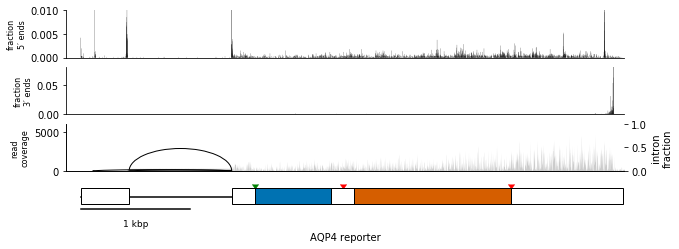

In [11]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats as stats
import numpy as np
plt.rcParams['pdf.fonttype'] = 42 #leaves most text as actual text in PDFs, not outlines
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

plots=[]
num_plots_wide = 1
num_plots_high = 4
fig, plots = plt.subplots(num_plots_high, figsize=(10*num_plots_wide, 1*num_plots_high), sharex=True)

positions = np.arange(5200)

ends_5p = np.array([float(pBZ147_5p_ends[pos]) for pos in positions])
ends_3p = np.array([float(pBZ147_3p_ends[pos]) for pos in positions])

plots[0].bar(positions-0.5, ends_5p/sum(ends_5p), color=black, linewidth=0, width=2, align='edge', alpha=1, snap=False, label='fraction 5prime ends')
plots[0].set_ylabel(u'fraction\n5′ ends', fontsize=8)
plots[0].set_ylim(0,0.01)

plots[1].bar(positions-0.5, ends_3p/sum(ends_3p), color=black, linewidth=0, width=2, align='edge', alpha=1, snap=False, label='fraction 3prime ends')
plots[1].set_ylabel(u'fraction\n3′ ends', fontsize=8)
plots[1].set_ylim(0,0.08)


coverage = np.array([float(pBZ147_coverage[pos]) for pos in positions])
#plots[2].bar(positions-0.5, coverage, color=gray, linewidth=0, width=1, align='edge', alpha=0.5, snap=False, label='fractional coverage')
plots[2].fill_between(positions, coverage, color=gray, linewidth=0, alpha=0.5, label='fractional coverage')
plots[2].set_ylabel('read\ncoverage', fontsize=8)
plots[2].set_ylim(0,6000)

#plots[2].set_yscale('log')

ax2 = plots[2].twinx()

for intron in pBZ147_normalized_introns.keys():
    arc = patches.Arc(((intron[1]+intron[0])/2., 0), intron[1]-intron[0], 2*pBZ147_normalized_introns[intron], linewidth=1)
    ax2.add_patch(arc)
    
ax2.set_ylabel('intron\nfraction')



for plot in plots:
    plot.spines["top"].set_visible(False)
    plot.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

#draw transcript
plots[3].set_ylim(0, 100)
transcript_bottom = 50

plots[3].plot([136, 4046], [transcript_bottom+15, transcript_bottom+15], color=black)
plots[3].add_patch(patches.Rectangle((136, transcript_bottom), (577+1)-(136), 35, facecolor="white", edgecolor = "black", zorder=10))
plots[3].add_patch(patches.Rectangle((1516, transcript_bottom), (5088+1)-(1516), 35, facecolor="white", edgecolor = "black", zorder=10))
plots[3].add_patch(patches.Rectangle((1724, transcript_bottom), (2422+1)-(1724), 35, facecolor=blue, edgecolor = "black", zorder=10)) 
plots[3].add_patch(patches.Rectangle((2633, transcript_bottom), 753+684, 35, facecolor=vermillion, edgecolor = "black", zorder=10)) 
#plots[3].add_patch(patches.Rectangle((3386, transcript_bottom), 684, 35, facecolor=vermillion, edgecolor = "black", zorder=10, hatch='\\\\\\')) 
plots[3].plot([1724], [85], marker=7, color="green")
plots[3].plot([2536], [85], marker=7, color="red")
plots[3].plot([4069], [85], marker=7, color="red")

plots[3].spines["bottom"].set_visible(False)
plots[3].spines["left"].set_visible(False)
plots[3].set_xlabel('AQP4 reporter')
plots[3].set_yticks([])
plots[3].set_xticks([])

plots[3].set_xlim(0, 5100)
size_of_scale = 1000
plots[3].plot([136, 136+size_of_scale], [40, 40], color=black)
plots[3].text(136+(size_of_scale/2),  0, "{} kbp".format(size_of_scale/1000), size=9, horizontalalignment='center', verticalalignment='bottom')

plt.savefig('pBZ147_AQP4_coverage.pdf', transparent=True)

use bedtools to compute genome coverage

In [12]:
import subprocess
reference = 'pBZ105_lenti_tagBF_2A_UGAC_2A_tdTomato'
bam_file = 'HEK293FT_pBZ105_UGAC.bam'
name = 'UGAC_reporter'
cmd='samtools view -u {bam_file} "{reference}" | bedtools genomecov -ibam stdin -dz -split -strand + | grep pBZ > {name}.cov.txt'.format(**locals())
print(cmd)
subprocess.Popen(cmd, shell=True).wait()
#bedtools genomecov -ibam NA18152.bam -bg -strand + | head

samtools view -u HEK293FT_pBZ105_UGAC.bam "pBZ105_lenti_tagBF_2A_UGAC_2A_tdTomato" | bedtools genomecov -ibam stdin -dz -split -strand + | grep pBZ > UGAC_reporter.cov.txt


0

In [13]:
import subprocess
reference = 'pBZ147_lenti_tagBF_2A_AQP4_2A_tdTomato'
bam_file = 'HEK293FT_pBZ147_AQP4.bam'
name = 'AQP4_reporter'
cmd='samtools view -u {bam_file} "{reference}" | bedtools genomecov -ibam stdin -dz -split -strand + | grep pBZ > {name}.cov.txt'.format(**locals())
print(cmd)
subprocess.Popen(cmd, shell=True).wait()
#bedtools genomecov -ibam NA18152.bam -bg -strand + | head

samtools view -u HEK293FT_pBZ147_AQP4.bam "pBZ147_lenti_tagBF_2A_AQP4_2A_tdTomato" | bedtools genomecov -ibam stdin -dz -split -strand + | grep pBZ > AQP4_reporter.cov.txt


0

In [14]:
from collections import defaultdict
def get_coverage(coverage_file, reference):
    coverage_dict = defaultdict(int)
    f = open(coverage_file)
    for line in f:
        chrom, position, coverage = line.strip().split()
        if chrom == reference:
            coverage_dict[int(position)] = int(coverage)
    return coverage_dict
pBZ105_coverage = {}
name = 'UGAC_reporter'
cov_file = '{name}.cov.txt'.format(**locals())
pBZ105_coverage[name] = get_coverage(cov_file, 'pBZ105_lenti_tagBF_2A_UGAC_2A_tdTomato')
pBZ147_coverage = {}
name = 'AQP4_reporter'
cov_file = '{name}.cov.txt'.format(**locals())
pBZ147_coverage[name] = get_coverage(cov_file, 'pBZ147_lenti_tagBF_2A_AQP4_2A_tdTomato')

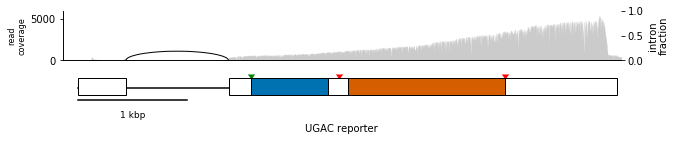

In [15]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats as stats
import numpy as np
plt.rcParams['pdf.fonttype'] = 42 #leaves most text as actual text in PDFs, not outlines
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

plots=[]
num_plots_wide = 1
num_plots_high = 2
fig, plots = plt.subplots(num_plots_high, figsize=(10*num_plots_wide, 1*num_plots_high), sharex=True)

positions = np.arange(5200)


coverage = np.array([float(pBZ105_coverage['UGAC_reporter'][pos]) for pos in positions])
#plots[2].bar(positions-0.5, coverage, color=gray, linewidth=0, width=1, align='edge', alpha=0.5, snap=False, label='fractional coverage')
plots[0].fill_between(positions, coverage, color=gray, linewidth=0, alpha=0.5, label='fractional coverage')
plots[0].set_ylabel('read\ncoverage', fontsize=8)
plots[0].set_ylim(0,6000)

#plots[2].set_yscale('log')

ax2 = plots[0].twinx()

for intron in pBZ105_normalized_introns.keys():
    arc = patches.Arc(((intron[1]+intron[0])/2., 0), intron[1]-intron[0], 2*pBZ105_normalized_introns[intron], linewidth=1)
    ax2.add_patch(arc)
    
ax2.set_ylabel('intron\nfraction')

for plot in plots:
    plot.spines["top"].set_visible(False)
    plot.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

#draw transcript
plots[1].set_ylim(0, 100)
transcript_bottom = 50

plots[1].plot([136, 4046], [transcript_bottom+15, transcript_bottom+15], color=black)
plots[1].add_patch(patches.Rectangle((136, transcript_bottom), (577+1)-(136), 35, facecolor="white", edgecolor = "black", zorder=10))
plots[1].add_patch(patches.Rectangle((1516, transcript_bottom), (5064+1)-(1516), 35, facecolor="white", edgecolor = "black", zorder=10))
plots[1].add_patch(patches.Rectangle((1724, transcript_bottom), (2422+1)-(1724), 35, facecolor=blue, edgecolor = "black", zorder=10)) 
plots[1].add_patch(patches.Rectangle((2609, transcript_bottom), 753+684, 35, facecolor=vermillion, edgecolor = "black", zorder=10)) 
#plots[3].add_patch(patches.Rectangle((3362, transcript_bottom), 684, 35, facecolor=vermillion, edgecolor = "black", zorder=10, hatch='\\\\\\')) 
plots[1].plot([1724], [85], marker=7, color="green")
plots[1].plot([2521], [85], marker=7, color="red")
plots[1].plot([4045], [85], marker=7, color="red")


plots[1].spines["bottom"].set_visible(False)
plots[1].spines["left"].set_visible(False)
plots[1].set_xlabel('UGAC reporter')
plots[1].set_yticks([])
plots[1].set_xticks([])

plots[1].set_xlim(0, 5100)
size_of_scale = 1000
plots[1].plot([136, 136+size_of_scale], [40, 40], color=black)
plots[1].text(136+(size_of_scale/2),  0, "{} kbp".format(size_of_scale/1000), size=9, horizontalalignment='center', verticalalignment='bottom')

plt.savefig('pBZ105_UGAC_coverage2.pdf', transparent=True)

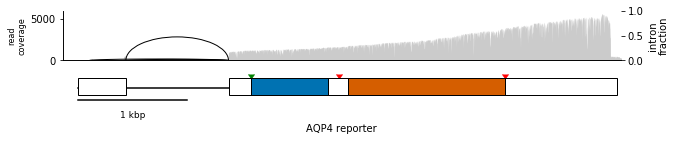

In [16]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats as stats
import numpy as np
plt.rcParams['pdf.fonttype'] = 42 #leaves most text as actual text in PDFs, not outlines
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

plots=[]
num_plots_wide = 1
num_plots_high = 2
fig, plots = plt.subplots(num_plots_high, figsize=(10*num_plots_wide, 1*num_plots_high), sharex=True)

positions = np.arange(5200)


coverage = np.array([float(pBZ147_coverage['AQP4_reporter'][pos]) for pos in positions])
#plots[2].bar(positions-0.5, coverage, color=gray, linewidth=0, width=1, align='edge', alpha=0.5, snap=False, label='fractional coverage')
plots[0].fill_between(positions, coverage, color=gray, linewidth=0, alpha=0.5, label='fractional coverage')
plots[0].set_ylabel('read\ncoverage', fontsize=8)
plots[0].set_ylim(0,6000)

#plots[2].set_yscale('log')

ax2 = plots[0].twinx()

for intron in pBZ147_normalized_introns.keys():
    arc = patches.Arc(((intron[1]+intron[0])/2., 0), intron[1]-intron[0], 2*pBZ147_normalized_introns[intron], linewidth=1)
    ax2.add_patch(arc)
    
ax2.set_ylabel('intron\nfraction')

for plot in plots:
    plot.spines["top"].set_visible(False)
    plot.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

#draw transcript
plots[1].set_ylim(0, 100)
transcript_bottom = 50

plots[1].plot([136, 4046], [transcript_bottom+15, transcript_bottom+15], color=black)
plots[1].add_patch(patches.Rectangle((136, transcript_bottom), (577+1)-(136), 35, facecolor="white", edgecolor = "black", zorder=10))
plots[1].add_patch(patches.Rectangle((1516, transcript_bottom), (5064+1)-(1516), 35, facecolor="white", edgecolor = "black", zorder=10))
plots[1].add_patch(patches.Rectangle((1724, transcript_bottom), (2422+1)-(1724), 35, facecolor=blue, edgecolor = "black", zorder=10)) 
plots[1].add_patch(patches.Rectangle((2609, transcript_bottom), 753+684, 35, facecolor=vermillion, edgecolor = "black", zorder=10)) 
#plots[3].add_patch(patches.Rectangle((3362, transcript_bottom), 684, 35, facecolor=vermillion, edgecolor = "black", zorder=10, hatch='\\\\\\')) 
plots[1].plot([1724], [85], marker=7, color="green")
plots[1].plot([2521], [85], marker=7, color="red")
plots[1].plot([4045], [85], marker=7, color="red")


plots[1].spines["bottom"].set_visible(False)
plots[1].spines["left"].set_visible(False)
plots[1].set_xlabel('AQP4 reporter')
plots[1].set_yticks([])
plots[1].set_xticks([])

plots[1].set_xlim(0, 5100)
size_of_scale = 1000
plots[1].plot([136, 136+size_of_scale], [40, 40], color=black)
plots[1].text(136+(size_of_scale/2),  0, "{} kbp".format(size_of_scale/1000), size=9, horizontalalignment='center', verticalalignment='bottom')

plt.savefig('pBZ147_AQP4_coverage2.pdf', transparent=True)